In [12]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load Datasets

In [13]:
rotten_tomatoes_raw = pd.read_csv('rotten_tomatoes/movie_info.csv')

In [14]:
imdb_dict = dict()
num_rows = 0
for path in glob.glob(f'imdb/*.csv'):
    df = pd.read_csv(path)
    imdb_dict[path] = df
    num_rows += df.shape[0]

In [15]:
imdb_raw = pd.concat(imdb_dict.values(), ignore_index=True)

In [16]:
oscar_raw = pd.read_csv('oscar_award/full_data.csv', sep='\t')

## Data Cleaning

### Rotten Tomatoes Ratings

In [17]:
rotten_tomatoes = rotten_tomatoes_raw.dropna()
rotten_tomatoes['critic_score'] = rotten_tomatoes['critic_score'].apply(lambda x: float(x[:-1])/100)
rotten_tomatoes['audience_score'] = rotten_tomatoes['audience_score'].apply(lambda x: float(x[:-1])/100)
def clean_date(date):
    year = date[-4:]
    try:
        return int(year)
    except:
        return None
rotten_tomatoes['release_year'] = rotten_tomatoes['release_date'].apply(clean_date)
rotten_tomatoes = rotten_tomatoes.dropna()
rotten_tomatoes['release_year'] = rotten_tomatoes['release_year'].astype(int)
rotten_tomatoes = rotten_tomatoes.drop(columns='url')

/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/ipykernel_95946/2090178666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotten_tomatoes['critic_score'] = rotten_tomatoes['critic_score'].apply(lambda x: float(x[:-1])/100)
/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/ipykernel_95946/2090178666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotten_tomatoes['audience_score'] = rotten_tomatoes['audience_score'].apply(lambda x: float(x[:-1])/100)
/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/i

In [18]:
imdb = imdb_raw.drop_duplicates()
imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')
imdb.loc[~imdb['year'].between(1880, 2025), 'year'] = np.nan
imdb = imdb.dropna(subset=['year'])
imdb['year'] = imdb['year'].astype(int)
imdb['votes'] = imdb.groupby('movie_id')['votes'].transform(lambda ser: ser.mean())
imdb = imdb.drop_duplicates()

/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/ipykernel_95946/2601930290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')


In [19]:
imdb_tomatoes = rotten_tomatoes.merge(imdb, left_on=['title', 'release_year'], right_on=['movie_name', 'year'])

In [20]:
oscar = oscar_raw.iloc[:, :12]

In [21]:
imdb_tomatoes_oscar = imdb_tomatoes.merge(oscar, left_on='movie_id', right_on='FilmId')

In [22]:
rotten_tomatoes.drop_duplicates().to_csv('data/rotten_tomatoes.csv', index=False)
imdb_tomatoes.drop_duplicates().to_csv('data/imdb_tomatoes.csv', index=False)
imdb_tomatoes_oscar.drop_duplicates().to_csv('data/imdb_tomatoes_oscar.csv', index=False)

## EDA

       critic_score  audience_score
count   9239.000000     9239.000000
mean       0.574691        0.618560
std        0.276039        0.201007
min        0.000000        0.030000
25%        0.350000        0.460000
50%        0.610000        0.630000
75%        0.820000        0.790000
max        1.000000        1.000000


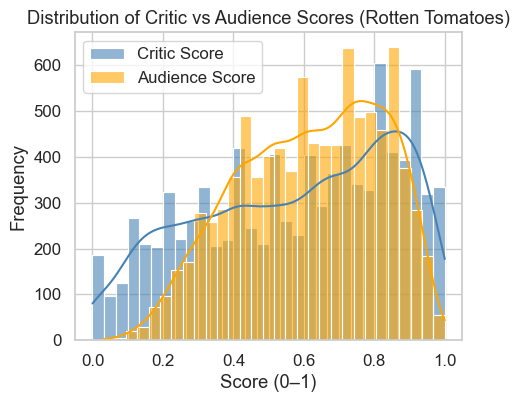

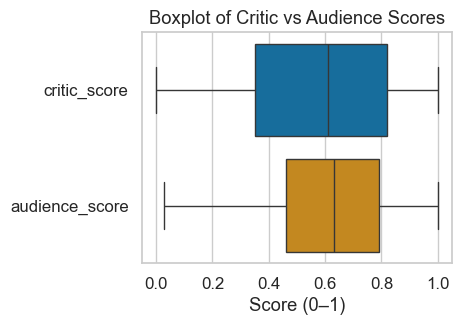

<Figure size 400x300 with 0 Axes>

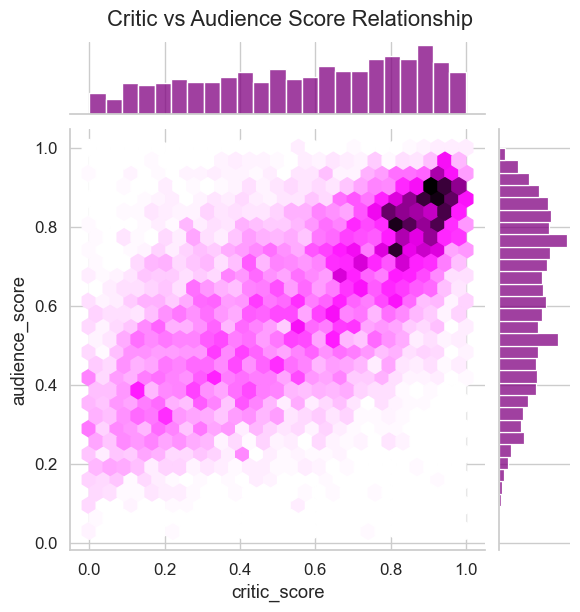

In [23]:
# set general plot aesthetics
sns.set(style="whitegrid", palette="colorblind", font_scale=1.1)

# inspect basic summary
print(rotten_tomatoes[['critic_score', 'audience_score']].describe())

# 1. histogram + KDE (kernel density estimate)
plt.figure(figsize=(5, 4))
sns.histplot(rotten_tomatoes['critic_score'], bins=30, kde=True, color='steelblue', label='Critic Score', alpha=0.6)
sns.histplot(rotten_tomatoes['audience_score'], bins=30, kde=True, color='orange', label='Audience Score', alpha=0.6)
plt.title('Distribution of Critic vs Audience Scores (Rotten Tomatoes)')
plt.xlabel('Score (0–1)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 2. side-by-side boxplots
plt.figure(figsize=(4, 3))
sns.boxplot(data=rotten_tomatoes[['critic_score', 'audience_score']], orient='h')
plt.title('Boxplot of Critic vs Audience Scores')
plt.xlabel('Score (0–1)')
plt.show()

# 3. optional: joint distribution (relationship between critic and audience scores)
plt.figure(figsize=(4, 3))
sns.jointplot(
    data=rotten_tomatoes, 
    x='critic_score', 
    y='audience_score', 
    kind='hex', 
    color='purple'
)
plt.suptitle('Critic vs Audience Score Relationship', y=1.02)
plt.show()


Winner                       False         True 
critic_score   count  2.978000e+03  1.031000e+03
               mean   8.148925e-01  8.684966e-01
               std    1.639978e-01  1.161334e-01
               min    8.000000e-02  1.700000e-01
               25%    7.600000e-01  8.400000e-01
               50%    8.600000e-01  9.100000e-01
               75%    9.300000e-01  9.400000e-01
               max    1.000000e+00  1.000000e+00
audience_score count  2.978000e+03  1.031000e+03
               mean   8.004231e-01  8.463240e-01
               std    1.303068e-01  1.086026e-01
               min    1.900000e-01  2.000000e-01
               25%    7.400000e-01  8.100000e-01
               50%    8.300000e-01  8.700000e-01
               75%    8.900000e-01  9.200000e-01
               max    9.900000e-01  9.900000e-01
rating         count  2.935000e+03  1.025000e+03
               mean   7.466440e+00  7.869951e+00
               std    7.143013e-01  6.589635e-01
               min  

/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/ipykernel_95946/2119436877.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  imdb_tomatoes_oscar['Winner'] = imdb_tomatoes_oscar['Winner'].fillna(False).astype(bool)


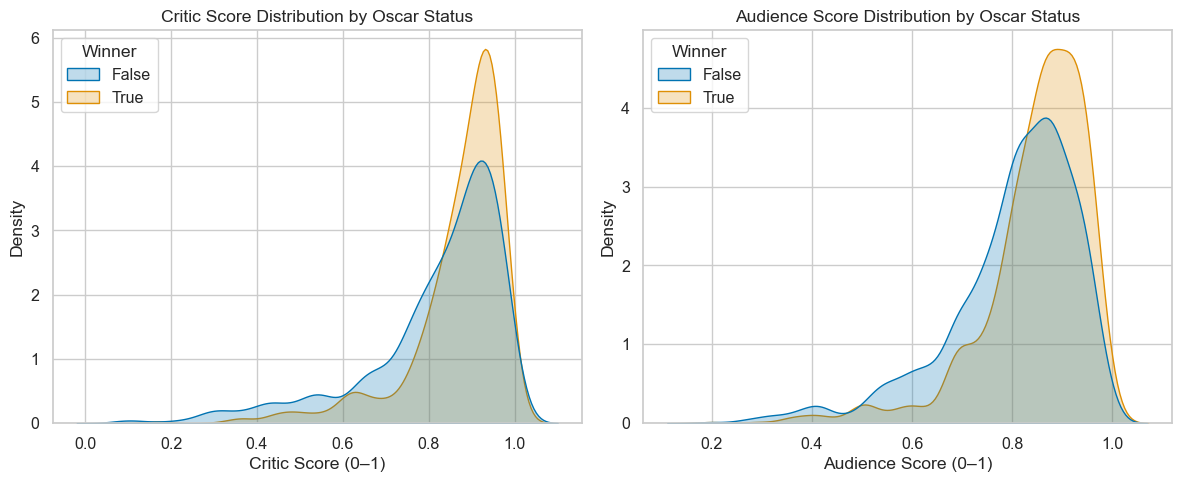

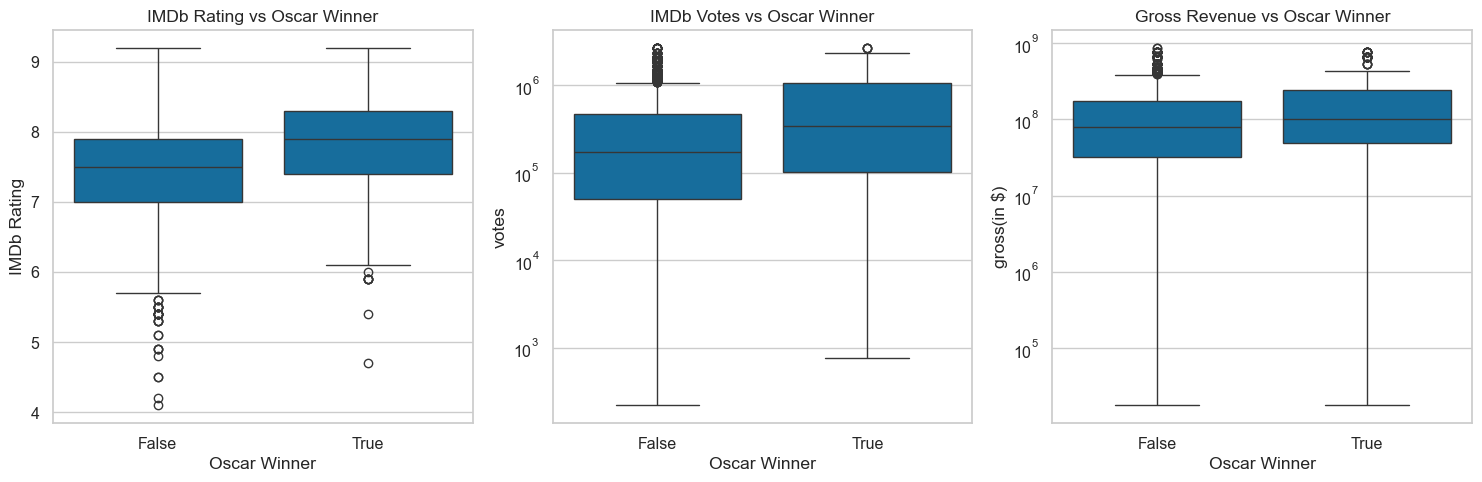

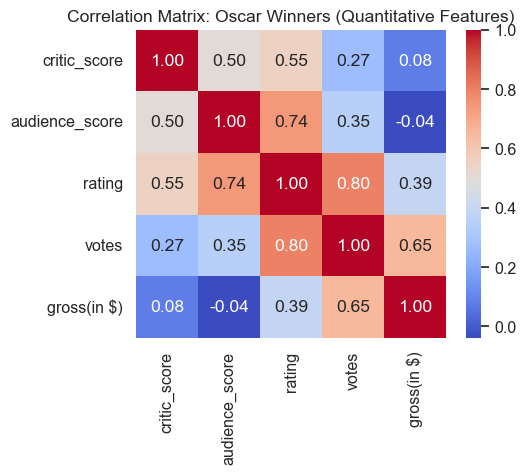

In [24]:
# ensure Winner is boolean
imdb_tomatoes_oscar['Winner'] = imdb_tomatoes_oscar['Winner'].fillna(False).astype(bool)

# define key quantitative features to compare
quant_cols = ['critic_score', 'audience_score', 'rating', 'votes', 'gross(in $)']

# summary stats by Winner
summary = imdb_tomatoes_oscar.groupby('Winner')[quant_cols].describe().T
print(summary)

# set up seaborn style
sns.set(style="whitegrid", palette="colorblind", font_scale=1.05)

# 1. KDE distributions for critic and audience scores
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(
    data=imdb_tomatoes_oscar, x='critic_score', hue='Winner',
    fill=True, common_norm=False, ax=axes[0]
)
axes[0].set_title("Critic Score Distribution by Oscar Status")
axes[0].set_xlabel("Critic Score (0–1)")

sns.kdeplot(
    data=imdb_tomatoes_oscar, x='audience_score', hue='Winner',
    fill=True, common_norm=False, ax=axes[1]
)
axes[1].set_title("Audience Score Distribution by Oscar Status")
axes[1].set_xlabel("Audience Score (0–1)")
plt.tight_layout()
plt.show()

# 2. Boxplots for IMDb rating, votes, and gross revenue
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=imdb_tomatoes_oscar, x='Winner', y='rating', ax=axes[0])
axes[0].set_title("IMDb Rating vs Oscar Winner")
axes[0].set_xlabel("Oscar Winner")
axes[0].set_ylabel("IMDb Rating")

sns.boxplot(data=imdb_tomatoes_oscar, x='Winner', y='votes', ax=axes[1])
axes[1].set_yscale('log')  # skewed distribution
axes[1].set_title("IMDb Votes vs Oscar Winner")
axes[1].set_xlabel("Oscar Winner")

sns.boxplot(data=imdb_tomatoes_oscar, x='Winner', y='gross(in $)', ax=axes[2])
axes[2].set_yscale('log')
axes[2].set_title("Gross Revenue vs Oscar Winner")
axes[2].set_xlabel("Oscar Winner")
plt.tight_layout()
plt.show()

# 3. Optional: correlation heatmap for numeric features among Oscar winners only
winners_corr = imdb_tomatoes_oscar[imdb_tomatoes_oscar['Winner'] == True][quant_cols].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(winners_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Oscar Winners (Quantitative Features)")
plt.show()


Critic score outliers: 0 rows
Audience score outliers: 0 rows


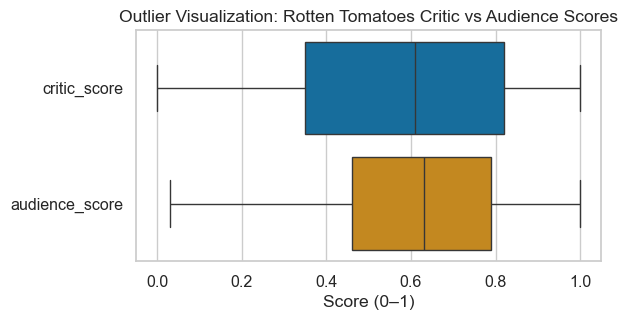

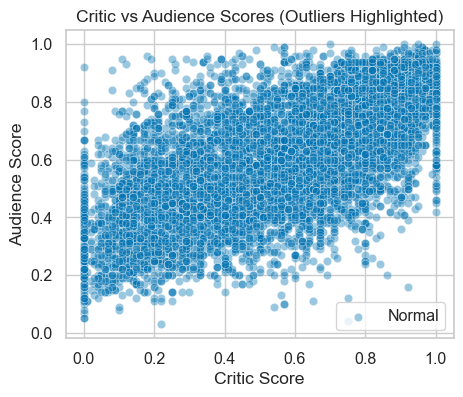

Oscar merged data - Critic score outliers: 313 rows
Oscar merged data - Audience score outliers: 189 rows


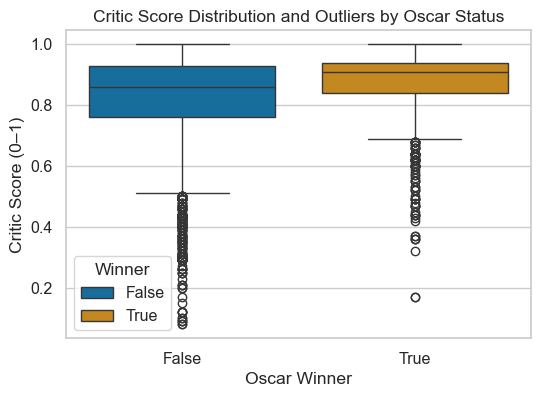

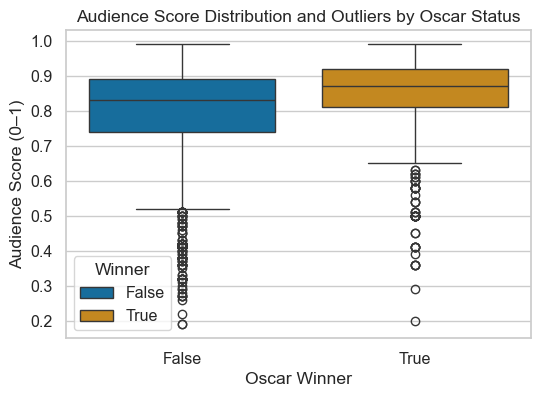

Top 5 lowest critic scores:


,title,critic_score,audience_score
265,The Villain,0.0,0.39
476,The Thing With Two Heads,0.0,0.25
477,The Thing With Two Heads,0.0,0.25
481,Night of the Lepus,0.0,0.27
715,Homecoming,0.0,0.33


Top 5 highest critic scores:


,title,critic_score,audience_score
6,Woodstock,1.0,0.92
16,Days and Nights in the Forest,1.0,0.97
29,The Butcher,1.0,0.84
42,Woodstock,1.0,0.92
90,On a Clear Day You Can See Forever,1.0,0.75


In [25]:
# --- Helper function for IQR-based outlier detection ---
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers, lower, upper


# ========================================================
# 1️⃣ Rotten Tomatoes Dataset Outliers
# ========================================================
outliers_critic, lower_c, upper_c = detect_outliers(rotten_tomatoes, 'critic_score')
outliers_audience, lower_a, upper_a = detect_outliers(rotten_tomatoes, 'audience_score')

print(f"Critic score outliers: {len(outliers_critic)} rows")
print(f"Audience score outliers: {len(outliers_audience)} rows")

# --- Boxplot visualization ---
plt.figure(figsize=(6, 3))
sns.boxplot(data=rotten_tomatoes[['critic_score', 'audience_score']], orient='h')
plt.title('Outlier Visualization: Rotten Tomatoes Critic vs Audience Scores')
plt.xlabel('Score (0–1)')
plt.show()

# --- Scatter plot highlighting outliers ---
plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=rotten_tomatoes, x='critic_score', y='audience_score', alpha=0.4, label='Normal'
)
sns.scatterplot(
    data=outliers_critic, x='critic_score', y='audience_score', color='red', label='Critic Outlier'
)
sns.scatterplot(
    data=outliers_audience, x='critic_score', y='audience_score', color='orange', label='Audience Outlier'
)
plt.title('Critic vs Audience Scores (Outliers Highlighted)')
plt.xlabel('Critic Score')
plt.ylabel('Audience Score')
plt.legend()
plt.show()


# ========================================================
# 2️⃣ IMDb + Rotten Tomatoes + Oscar Dataset Outliers
# ========================================================
outliers_critic_oscar, lower_c2, upper_c2 = detect_outliers(imdb_tomatoes_oscar, 'critic_score')
outliers_audience_oscar, lower_a2, upper_a2 = detect_outliers(imdb_tomatoes_oscar, 'audience_score')

print(f"Oscar merged data - Critic score outliers: {len(outliers_critic_oscar)} rows")
print(f"Oscar merged data - Audience score outliers: {len(outliers_audience_oscar)} rows")

# --- Boxplot visualization by Oscar status ---
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=imdb_tomatoes_oscar, 
    x='Winner', 
    y='critic_score', 
    hue='Winner',
    palette='colorblind'
)
plt.title('Critic Score Distribution and Outliers by Oscar Status')
plt.xlabel('Oscar Winner')
plt.ylabel('Critic Score (0–1)')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=imdb_tomatoes_oscar, 
    x='Winner', 
    y='audience_score', 
    hue='Winner',
    palette='colorblind'
)
plt.title('Audience Score Distribution and Outliers by Oscar Status')
plt.xlabel('Oscar Winner')
plt.ylabel('Audience Score (0–1)')
plt.show()


# ========================================================
# 3️⃣ Optional: List Top Extreme Outliers for Inspection
# ========================================================
print("Top 5 lowest critic scores:")
display(rotten_tomatoes.nsmallest(5, 'critic_score')[['title', 'critic_score', 'audience_score']])

print("Top 5 highest critic scores:")
display(rotten_tomatoes.nlargest(5, 'critic_score')[['title', 'critic_score', 'audience_score']])
